In [ ]:
#Adbanced Machine Learning
#Programming Assignment I: Gaussian Process Regression
#Name: Deepak Mewada
#RollNo.: 20CS91P02

#The objective of this assignment is to predict the 
#number of new COVID-19 cases in India and the World using
#Gaussian Process Regression. 


In [ ]:


#Mounting the Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:


#loading data from Gdrive & checking shape
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

series=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/new_casesWorld-India.csv')
data = np.array(series)

print(data.shape)
print(data)

(266, 4)
[[1 '31-12-2019' 27 0]
 [2 '01-01-2020' 0 0]
 [3 '02-01-2020' 0 0]
 ...
 [264 '19-09-2020' 309844 93337]
 [265 '20-09-2020' 294862 92605]
 [266 '21-09-2020' 253567 86961]]


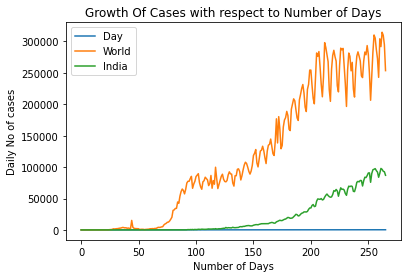

In [ ]:


#Visualise Data on Graph
series.plot(title='Growth Of Cases with respect to Number of Days' ,xlabel='Number of Days',ylabel='Daily No of cases')
plt.savefig('D:\IIT KGP\1st Semester\AML\Assignment\Growth Of Cases wrt no of days',dpi=80)
plt.show()

In [ ]:


#Taking No. of Day as feature(x) & No of Cases/day as Target Vector(y). 
#After that Dividing Data as Training(day0 to day246 ) and Test set(day246 to day266)  
training_data=data[0:245]
x=data[:, [0]]
yWorld=data[:, [2]]
yIndia=data[:, [3]]

x_train=data[0:246, [0]]
y_train=data[0:246, [2,3]]
yWorld_train=data[0:246, [2]]
yIndia_train=data[0:246, [3]]

x_test=data[246:, [0]]
yWorld_test=data[246:, [2]]
yIndia_test=data[246:, [3]]


In [ ]:


#Defining Kernel :Here, I used the squared exponential kernel, also known as Gaussian kernel or RBF kernel.
#The length parameter 'l' controls the smoothness of the function and 'σf' the vertical variation
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    sqdist =sqdist.astype(float)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [ ]:

from matplotlib.pyplot import figure
#Definig plot_gp to plot graph of distributions
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[],title='Distribution'):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    figure(num=None, figsize=(10,6), dpi=80)
    
    plt.xticks(range(0,350,10))
    plt.fill_between(X, (mu + uncertainty), (mu - uncertainty), alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'ko',label='Training Data')
    plt.title(title,fontsize=13,color='r')
    plt.legend()
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/AML/%(title)s.png' % locals(),dpi=80)


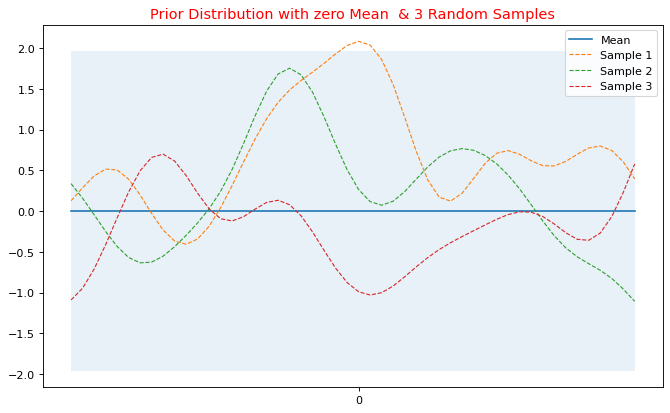

In [ ]:


#PRIOR :Defining a prior over functions with mean zero and a covariance matrix computed with kernel parameters
# Finite number of points
X =np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples,title='Prior Distribution with zero Mean  & 3 Random Samples')

In [ ]:


#Defining Posterior_Pridictive Function: 
#To compute the sufficient statistics i.e. mean and covariance of the posterior predictive distribution
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

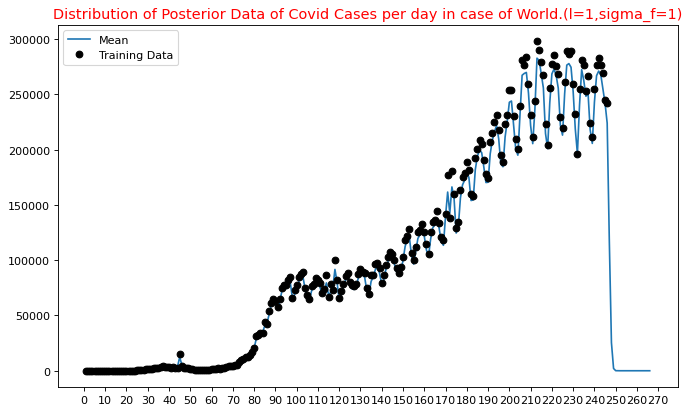

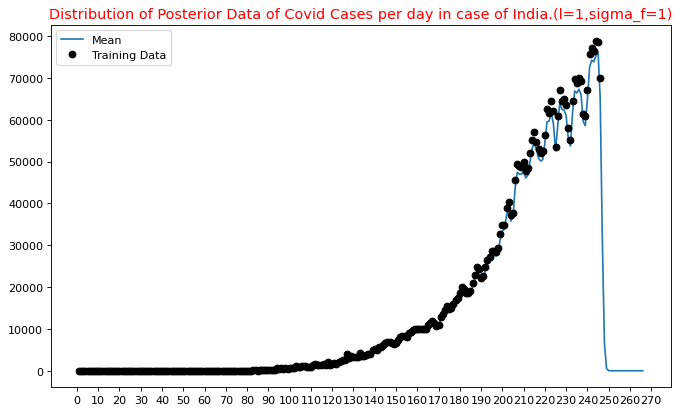

In [ ]:

 
# Findinig the Posterior Pridictive(with l=1,sigmaf=1) for Covid Cases in World and 
#ploting them along with the mean, confidence interval and training data
from numpy.linalg import inv
x=x.astype(float)
x_test=x_test.astype(float)
x_train=x_train.astype(float)
yWorld_train=yWorld_train.astype(float)

# Compute mean and covariance of the posterior predictive distribution for cases Worldwide
mu_s, cov_s = posterior_predictive(x, x_train, yWorld_train,1,1,np.sqrt(0.1))
mu_s=mu_s.astype(float)
cov_s=cov_s.astype(float)

plot_gp(mu_s, cov_s, x, X_train=x_train, Y_train=yWorld_train,title='Distribution of Posterior Data of Covid Cases per day in case of World.(l=1,sigma_f=1)')

# Compute mean and covariance of the posterior predictive distribution for Cases in India & ploting them along with the mean, confidence interval and training data
mu_s1, cov_s1 = posterior_predictive(x, x_train, yIndia_train,1,1,np.sqrt(0.1))
mu_s1=mu_s1.astype(float)
cov_s1=cov_s1.astype(float)

plot_gp(mu_s1, cov_s1, x, X_train=x_train, Y_train=yIndia_train,title='Distribution of Posterior Data of Covid Cases per day in case of India.(l=1,sigma_f=1)')

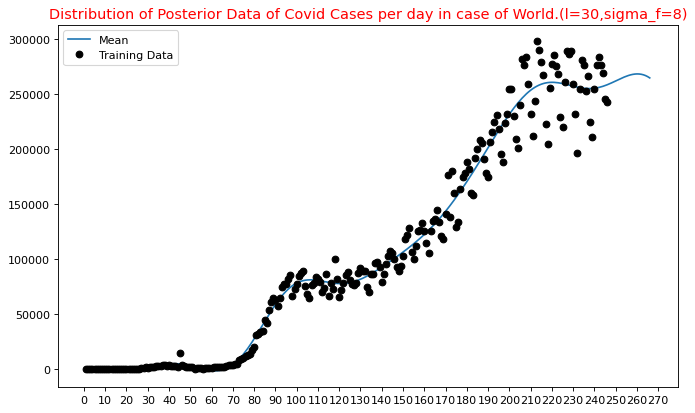

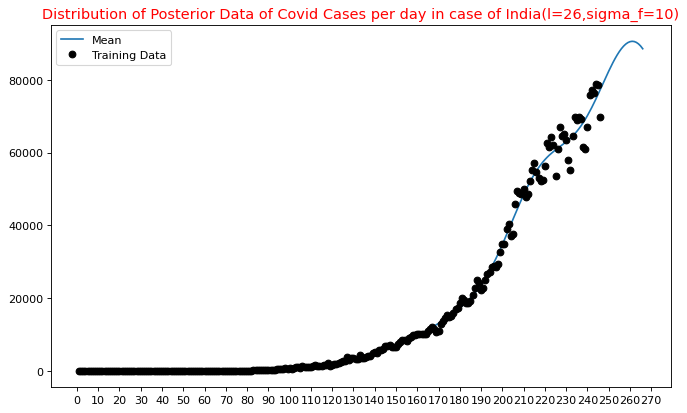

In [ ]:


#After Hyperparameter optimization we came to know about 'l' & 'f_sigma' values which give best approximation for our data
#Here for our data best hyperparameters found to be 
#For India, l = 26.0 and sigma_f = 10.0, 
#For World, l = 30.0 and sigma_f = 8.0, 

l=30
sigma_f=8
# Compute mean and covariance of the posterior predictive distribution for cases Worldwide
mu_s, cov_s = posterior_predictive(x, x_train, yWorld_train,l,sigma_f,np.sqrt(0.1))
mu_s=mu_s.astype(float)
cov_s=cov_s.astype(float)

plot_gp(mu_s, cov_s, x, X_train=x_train, Y_train=yWorld_train,title='Distribution of Posterior Data of Covid Cases per day in case of World.(l=30,sigma_f=8)')

# Compute mean and covariance of the posterior predictive distribution for Cases in India & ploting them along with the mean, confidence interval and training data
l=26
sigma_f=10
mu_s1, cov_s1 = posterior_predictive(x, x_train, yIndia_train,l,sigma_f,np.sqrt(0.1))
mu_s1=mu_s1.astype(float)
cov_s1=cov_s1.astype(float)

plot_gp(mu_s1, cov_s1, x, X_train=x_train, Y_train=yIndia_train,title='Distribution of Posterior Data of Covid Cases per day in case of India(l=26,sigma_f=10)')

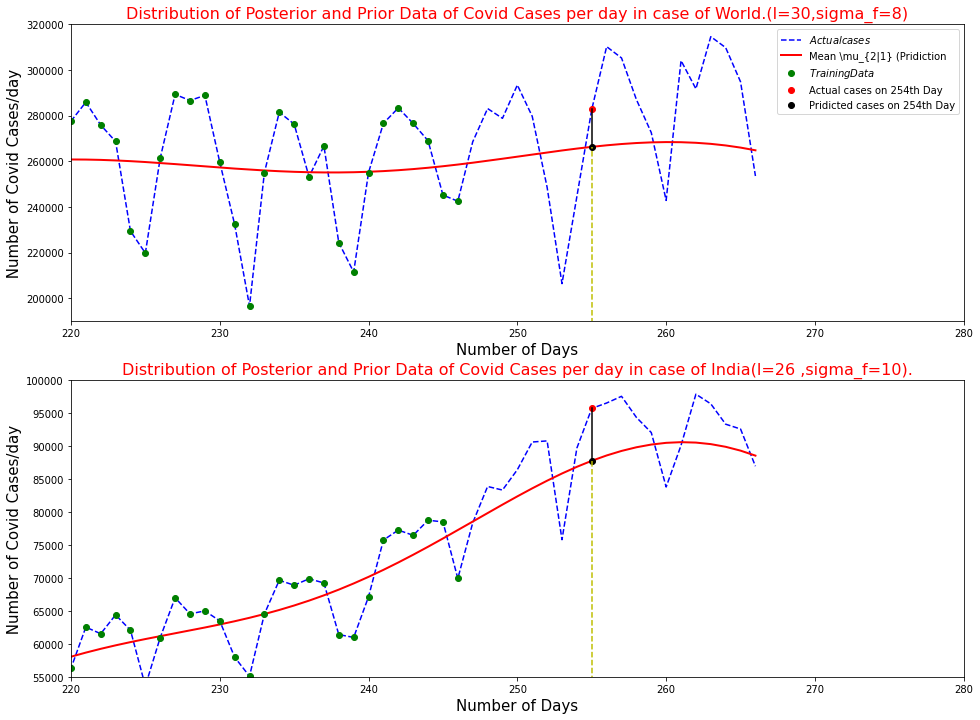

In [ ]:


#Replotting the Posterior Distribution with more clear visualisation & 
#Pricting the no of cases for 254th day from given model with otimal parameters
#Finally the comparision is plotted with the help of line and dots to show the difference in actual value & prediction.
l=30
sigma_f=8
mu_s, cov_s = posterior_predictive(x, x_train, yWorld_train,l,sigma_f,np.sqrt(0.1))
mu_s=mu_s.astype(float)
cov_s=cov_s.astype(float)

X2=x
μ2=mu_s.ravel()
σ2=np.sqrt(np.diag(cov_s))
X1=x_train
y1=yWorld_train
day=254

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
# Plot the distribution of the function (mean, covariance) for World's data
ax1.plot(X2 ,yWorld , 'b--', label='$Actual cases$')
ax1.plot(X2, μ2, 'r-', lw=2, label='Mean \mu_{2|1} (Pridiction')
ax1.plot(X1, y1, 'go', linewidth=2, label='$Training Data$')
ax1.plot(X2[day],yWorld[day],'ro',label='Actual cases on 254th Day')
ax1.plot(X2[day],μ2[day],'ko',label='Pridicted cases on 254th Day')
ax1.plot([X2[day],X2[day]],[μ2[day],yWorld[day]],'k')
ax1.set_xlabel('Number of Days', fontsize=15)
ax1.set_ylabel(' Number of Covid Cases/day ', fontsize=15)
ax1.set_title('Distribution of Posterior and Prior Data of Covid Cases per day in case of World.(l=30,sigma_f=8)',fontsize=16,color='r')
ax1.axis([220, 280, 190000, 320000])
ax1.plot([X2[day],X2[day]],[0,μ2[day]],'y--')
ax1.legend()

# Plot the distribution of the function (mean, covariance) for India's data
l=26
sigma_f=10

mu_s1, cov_s1 = posterior_predictive(x, x_train, yIndia_train,l,sigma_f,np.sqrt(0.1))
mu_s1=mu_s1.astype(float)
cov_s1=cov_s1.astype(float)

X2=x
μ2=mu_s1.ravel()
σ2=np.sqrt(np.diag(cov_s1))
X1=x_train
y1=yIndia_train
ax2.plot(X2 ,yIndia , 'b--', label='$Expected$')
ax2.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax2.plot(X1, y1, 'go', linewidth=2, label='$Training$')
ax2.plot(X2[day],yIndia[day],'ro',label='Actual cases on 254th Day')
ax2.plot(X2[day],μ2[day],'ko',label='Pridicted cases on 254th Day')
ax2.plot([X2[day],X2[day]],[μ2[day],yIndia[day]],'k')
ax2.set_xlabel('Number of Days', fontsize=15)
ax2.set_ylabel(' Number of Covid Cases/day ', fontsize=15)
ax2.set_title('Distribution of Posterior and Prior Data of Covid Cases per day in case of India(l=26 ,sigma_f=10).',fontsize=16,color='r')
ax2.axis([220, 280,55000,100000 ])
ax2.plot([X2[day],X2[day]],[0,μ2[day]],'y--')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/AML/Final',dpi=150)